In [ ]:
#Downloading files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Prject Title: Give ME some Credit

## Description of the project from Competition

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.


## Importing Necessary Libraries and setting styles

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

### Loading Data to Pandas Data Frame

In [ ]:
cs_Training_df = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-training.csv')
cs_test_df = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-test.csv')
sampleEntry_df = pd.read_csv('/kaggle/input/GiveMeSomeCredit/sampleEntry.csv')

In [ ]:
cs_Training_df.head()

In [ ]:
cs_Training_df.shape

In [ ]:
cs_test_df.shape

# Exploratory Data Analysis & Data Cleaning

In [ ]:
cs_Training_df.info()

We see that there are no object datatype in this training dataset.  so there is no need for encoding. Also there are missing values in two columns which we will deal with later.

The first column is unnecessary. So just drop this column.

In [ ]:
train_df = cs_Training_df.drop(columns = ['Unnamed: 0'])
train_df.head()
test_df = cs_test_df.drop(columns = ['Unnamed: 0', 'SeriousDlqin2yrs'])

In [ ]:
train_df.describe()

Lets draw a plot to understand the distribution of yes and no values in the target column. 

In [ ]:
sns.countplot(x='SeriousDlqin2yrs',data=train_df,palette='RdBu_r')
plt.title('Binary Class Comparison')

It is clear that Target Data is highly imbalanced. So, there is a possibility that ROC_AUC score might be low even though accuracy is high. So, we may try balancing the data later and see what happens.

In [ ]:
train_df.isnull().sum()

There are some missing values in Monthly Income and NumberOfDependents column. We can check out the distribution of Monthly Income and Number of Dependents Column and replace the missing values with appropriate values.  

In [ ]:
sns.histplot(data=train_df, x= 'MonthlyIncome', bins = 10)

In [ ]:
train_df.MonthlyIncome.median()

In [ ]:
train_df.MonthlyIncome.mean()

In [ ]:
train_df.MonthlyIncome.max()

Though the maximum income is very large than median it doesnt pull the mean from the median greatly. We can impute the missing Monthly Income values with both the median and the mean. 

Now, lets analyze the columns where information about late pay is given. 

In [ ]:
train_df["NumberOfTimes90DaysLate"].value_counts().sort_index()

In [ ]:
train_df["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()

In [ ]:
train_df["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

Look at the three columns value counts. It is clear that there is a sudden absense of values from 17 to 96 in "NumberOfTimes90DaysLate" column.For the other two columns there is also absence of values. It is bit unusual. Lets delete the rows with values greater than 17 to remove this ambiguity.

In [ ]:
train_df = train_df.drop(train_df[train_df.NumberOfTimes90DaysLate > 17].index)

## Setting Feature and Target Column

In [ ]:
X = train_df.drop(columns = ['SeriousDlqin2yrs'])
y = train_df['SeriousDlqin2yrs']

## Filling missing values

In [ ]:
X['MonthlyIncome'].fillna(X['MonthlyIncome'].mean(),inplace=True)
X['NumberOfDependents'].fillna(test_df['NumberOfDependents'].mode()[0], inplace=True)

In [ ]:
X.isna().sum()

Now there is no missing values in training data. 

# Model Type 1: Logistic Regression Model

## Import, split,scaling, fitting, training

In [ ]:
#Import scikit learn and necessary metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import sklearn.metrics as metrics


X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=1)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)


LRmodel = LogisticRegression(max_iter= 300, solver= 'lbfgs')
LRmodel.fit(X_train, y_train)

# implementing model and scoring
predictions = LRmodel.predict(X_valid)
print(classification_report(y_valid, predictions))
print("Accuracy:",metrics.accuracy_score(y_valid, predictions))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def predict_and_plot(inputs,targets,model, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

In [ ]:
val_preds = predict_and_plot(X_valid, y_valid, LRmodel, 'Validatiaon')

Though the accuracy score is high, we see bad results in F1 score and cofusion metrics. We will now use another metric called ROC AUC score which is used in the kaggle competition. 

## Logistic Regression ROC AUC with Untouched Data

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# predict probabilities
yhat = LRmodel.predict_proba(X_valid)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_valid, yhat)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic with Untouched data')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

# Under & Oversampling Skewed Data

Imbalance is a common phenomenon in Binary Classification Problem. Not surprisingly, there is a skewness in the target data in this problem also.This bias can influence many machine learning algorithm. And, it can cause ignoring minority class entirely. The problem can be reduced by wither undersampling majority class or oversampling minority class or finding a sweet spot between the two. So, we would use the last approach to improve performance of some of the models. Lets see what happens when we deliberately balance the imbalanced data and how it affects the ROC AUC score in validation and test data.

To know more: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [ ]:
!pip install delayed
from imblearn.combine import SMOTEENN

# define sampling strategy
sample = SMOTEENN(sampling_strategy=0.5)
# fit and apply the transform
X_over, y_over = sample.fit_resample(X, y)



In [ ]:
X_train_new, X_valid_new, y_train_new, y_valid_new = train_test_split(X_over, y_over, train_size=0.8, test_size=0.2,random_state=2)
scaler1 = StandardScaler().fit(X_train_new)
X_train_new = scaler1.transform(X_train_new)
X_valid_new = scaler1.transform(X_valid_new)

LRmodelBalanced = LogisticRegression(max_iter= 300, solver= 'lbfgs')

LRmodelBalanced.fit(X_train_new, y_train_new)

# implementing model and scoring
predictions = LRmodelBalanced.predict(X_valid_new)
print(classification_report(y_valid_new, predictions))
print("Accuracy:",metrics.accuracy_score(y_valid_new, predictions))

Here you can see, with a reduced accuracy score, the models precision, recall and f1 score has improved greatly with the balacned data. 

We can also look at the confusion metrics for balanced data to have a good visualization of what is happenning. 

In [ ]:
val_preds = predict_and_plot(X_valid_new, y_valid_new, LRmodelBalanced, 'Validatiaon')

In the above plot we see though the accuracy score is reduced, confusion metrics has improved greatly.

## Logistic Regression ROC AUC with Balanced Data

In [ ]:
# predict probabilities
yhat = LRmodelBalanced.predict_proba(X_valid_new)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_valid_new, yhat)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid_new, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic with Balanced data')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Clearly ROC AUC score is slightly greater in the Balanced Data than the raw data.  

## Now, we will try other models to improve our ROC AUC score

# Model type 2: Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=220)
rfc_model.fit(X_train, y_train)
# predict probabilities
yhat = rfc_model.predict_proba(X_valid)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate scores
rfc_auc = roc_auc_score(y_valid, yhat)
# summarize scores
print('Random Forest: ROC AUC=%.3f' % (rfc_auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Random Forest with untouched data')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
rfc_model_balanced = RandomForestClassifier(n_estimators=220)
rfc_model_balanced.fit(X_train_new, y_train_new)
# predict probabilities
yhat = rfc_model_balanced.predict_proba(X_valid_new)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate scores
rfc_auc = roc_auc_score(y_valid_new, yhat)
# summarize scores
print('Random Forest: ROC AUC=%.3f' % (rfc_auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid_new, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Random Forest with Balanced data')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

ROC AUC score is higher for balanced data. 

# Model Type 3: XGBoost

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_jobs = -1, n_estimators = 220, random_state= 2)
xgb_model.fit(X_train, y_train)
# predict probabilities
yhat = xgb_model.predict_proba(X_valid)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate scores
rfc_auc = roc_auc_score(y_valid, yhat)
# summarize scores
print('XGboost: ROC AUC=%.3f' % (rfc_auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='XGboost with Untouched data')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
import xgboost as xgb
xgb_model_balanced = xgb.XGBClassifier(n_jobs = -1, n_estimators = 220, random_state=3)
xgb_model_balanced.fit(X_train_new, y_train_new)
# predict probabilities
yhat = xgb_model_balanced.predict_proba(X_valid_new)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate scores
rfc_auc = roc_auc_score(y_valid_new, yhat)
# summarize scores
print('XGboost: ROC AUC=%.3f' % (rfc_auc))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid_new, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='XGboost with Balanced data')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

# Score Summary

Now, we will present a summary of our models in a pandas dataframe.

In [ ]:
data = {'Name': ['Logistic Regression', 'Rabdom Forest', 'XGboost'], 'ROC_AUC': [0.807,0.842,0.845], 'ROC_AUC_Balanced':[0.827,0.974,0.956]}  
summary_df = pd.DataFrame(data)  
summary_df

# How to submit in the Kaggle Competition

You can follow the following procedure to submit in the kaggle competitiom

In [ ]:
#check missing values in test data
test_df.isnull().sum()

In [ ]:
#fill them with appropriate condition
test_df['MonthlyIncome'].fillna(test_df['MonthlyIncome'].mean(),inplace=True)
test_df['NumberOfDependents'].fillna(test_df['NumberOfDependents'].mode()[0], inplace=True)

In [ ]:
#scale test values 
test_df= scaler.transform(test_df)

In [ ]:
#predict with a model
test_pred=LRmodel.predict_proba(test_df)[:,1]

In [ ]:
# Change the values of sample file with our predictions
sampleEntry_df["Probability"]= test_pred
sampleEntry_df.head()

In [ ]:
# Convert to CSV file
sampleEntry_df.to_csv("submission.csv",index=False)

Now download the file using following command and upload on kaggle
```
from google.colab import files
files.download("submission.csv")
```



# Kaggle Submission

We submitted few late submissions during the project in kaggle competition for our dataset and got these scores. The best scores are highlighted with yellow color.

NB: After these submission, we changed some parameters and tested some other data engineering techniques. So our current model may give a slightly higher or lower score if you submit with the current models. 

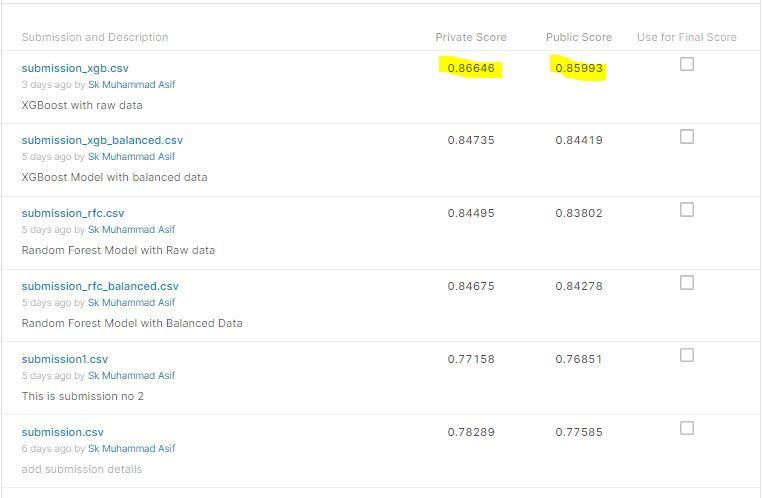

NB: You May get different results as we did some tuning and engineering to data after these submissions.

# Insights

During this project, I gained some valuable insight which I would like to share with you. 

*   You have to always carefully observe to understand the imbalance in target data in classification problem.
*   Accuracy score doesnt give the true picture about your model in classification problem. You should use precision-recall curve, ROC-AUC curve and confusion metrics to understand the weaknesses of your model better.



# Results & Conclusion

1. The model that performed best in our project is XGboost.
2. ROC AUC scores increased while we deliberately balanced our data. 
3. In case of, logistic Regression & Random forest models we got improved ROC AUC score when submitted to competition.
4. XGboost Model performed better with the untouched data in competition. 
5. Feature scaling improved the performance of our models. 
6. We thought, removing values greater than 17 in "NumberOfTimes90DaysLate" column would improve ROC AUC score. While it improved score in Logistic Regression model but failed to do well in other two models. 

# Recommendation for further works

1. Some other models can be applied such as LightGbm, decision tree classifier to check their performance in the data.
2. It can be checked how the model performs without removing the values greater than 17 in "NumberOfTimes90DaysLate" column. We checked it and got better accuracy in some of the models. 
3. While imputing missing values in Monthly Income, Median instead of Mode can be tried to see the performance. 

# Reference & Important Links

1.https://machinelearningmastery.com/imbalanced-classification-with-python-7-day-mini-course/

2.https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/